In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
# import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100, kind="biosemi64")
fwd = create_forward_model(sampling="ico3", info=info)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

# import mne
# from scipy.sparse.csgraph import laplacian

# adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
# laplace_operator = abs(laplacian(adjacency))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.7s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.2s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


# Models

## The Generator

In [3]:

import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Input, Lambda, LayerNormalization, Bidirectional, multiply
from tensorflow.keras.layers import Activation, Dropout, ActivityRegularization, TimeDistributed, Reshape, Permute, GaussianNoise, add
from tensorflow.keras.layers import Conv1D, Flatten, GRU
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
# import tensorflow_probability as tfp
from tensorflow.keras.regularizers import l1, l2, l1_l2

def define_model(n_layers=2, n_filters=64, learning_rate=0.001):
    tf.keras.backend.image_data_format() == 'channels_last'
    input_shape = (None, n_chans, 1)
    activation = "relu"

    inputs = tf.keras.Input(shape=input_shape, name='Input_CNN')
    fc = TimeDistributed(Conv1D(n_filters, n_chans, activation=activation, name="HL_D1"))(inputs)
    fc = TimeDistributed(Flatten())(fc)
    
    
    out = TimeDistributed(Dense(n_dipoles, activation="tanh", name="Output_Final"))(fc)
    
    model = tf.keras.Model(inputs=inputs, outputs=out, name='Discriminator_CNN')
    # model.add_loss(l1_sparsity(out))
    model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model


def define_model_temporal(n_lstm_units=32, n_layers=2, n_filters=64, learning_rate=0.001):
    tf.keras.backend.image_data_format() == 'channels_last'
    input_shape = (None, n_chans, 1)
    activation = "tanh"

    inputs = tf.keras.Input(shape=input_shape, name='Input_CNN')
    fc = TimeDistributed(Conv1D(n_filters, n_chans, activation=activation, name="HL_D1"))(inputs)
    fc = TimeDistributed(Flatten())(fc)
        
    # LSTM path
    # LSTM Path
    lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True), name='GRU')(fc)
    mask = TimeDistributed(Dense(n_dipoles, activation="sigmoid"), name='Mask')(lstm1)
    
    direct_out = TimeDistributed(Dense(n_dipoles, activation="tanh", name="Output_Final"))(fc)
    multi = multiply([direct_out, mask], name="multiply")

    model = tf.keras.Model(inputs=inputs, outputs=multi, name='Discriminator_CNN')
    model.add_loss(l1_sparsity(multi)*1e2)
    model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

def define_fc_model_temporal(n_lstm_units=32, n_neurons=200, learning_rate=0.001):
    tf.keras.backend.image_data_format() == 'channels_last'
    input_shape = (None, n_chans)
    activation = "tanh"

    inputs = tf.keras.Input(shape=input_shape, name='Input_FC')
    fc = TimeDistributed(Dense(n_neurons, activation=activation, name="HL_D1"))(inputs)
    fc = TimeDistributed(Flatten())(fc)
        
    # LSTM path
    # LSTM Path
    lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True), name='GRU')(fc)
    mask = TimeDistributed(Dense(n_dipoles, activation="sigmoid"), name='Mask')(lstm1)
    
    direct_out = TimeDistributed(Dense(n_dipoles, activation="tanh", name="Output_Final"))(fc)
    multi = multiply([direct_out, mask], name="multiply")

    model = tf.keras.Model(inputs=inputs, outputs=multi, name='Discriminator_FC')
    model.add_loss(l1_sparsity(multi)*1e2)
    model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

def prep_data(X, y):
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)
    return X, y
    
def prep_data_sim(sim):
    X = np.squeeze(np.stack([eeg.average().data for eeg in sim.eeg_data]))
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.squeeze(np.stack([src.data for src in sim.source_data]))
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)

    if len(X.shape) == 2:
        X = np.expand_dims(X, axis=-1)
        y = np.expand_dims(y, axis=-1)
    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    return X, y

def generate_samples(g_model, batch_size, latent_dim):
    x_input = np.random.randn(batch_size, latent_dim)
    sources = g_model.predict(x_input)
    return sources


def l1_sparsity(x):
    return K.mean(K.abs(x)) 
def l1_l2_ratio(x):
    return K.mean(K.abs(x)) / K.mean(K.square(x))
n_epochs = 200
batch_size = 32
batch_number = 10
latent_dim = 16
d =  define_model_temporal()


# Simulate

In [4]:
settings = dict(duration_of_trial=0.2, extents=(1, 40), number_of_sources=(1,15), target_snr=1e99)
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=5000)
X_train = np.stack([eeg.average().data for eeg in sim.eeg_data], axis=0)
y_train = np.stack([source.data for source in sim.source_data], axis=0)
X_train, y_train = prep_data(X_train, y_train)

X_train = np.swapaxes(X_train, 1, 2)
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.swapaxes(y_train, 1, 2)
y_train = np.expand_dims(y_train, axis=-1)

Simulating data based on sparse patches.


100%|██████████| 5000/5000 [00:53<00:00, 94.14it/s]


# Train

In [46]:
from tqdm.notebook import tqdm
n_chans, n_dipoles = leadfield.shape

model_kwargs = dict(n_filters=1284, n_layers=2, learning_rate=0.001)
train_kwargs = dict(validation_split=0.15, epochs=20, batch_size=8)

model = define_model_temporal(**model_kwargs)
model.summary()
model.fit(X_train, y_train, **train_kwargs)

# model_kwargs = dict(n_neurons=64, learning_rate=0.001)
# model_fc = define_fc_model_temporal(**model_kwargs)
# model_fc.summary()
# model_fc.fit(X_train[:,:,:,0], y_train[:,:,:,0], **train_kwargs)

Model: "Discriminator_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_CNN (InputLayer)          [(None, None, 64, 1) 0                                            
__________________________________________________________________________________________________
time_distributed_36 (TimeDistri (None, None, 1, 1284 83460       Input_CNN[0][0]                  
__________________________________________________________________________________________________
time_distributed_37 (TimeDistri (None, None, 1284)   0           time_distributed_36[0][0]        
__________________________________________________________________________________________________
GRU (Bidirectional)             (None, None, 64)     253056      time_distributed_37[0][0]        
__________________________________________________________________________________

KeyboardInterrupt: 

(64, 1284)


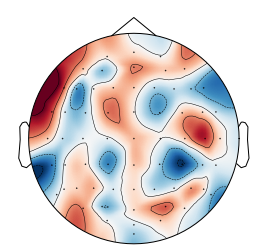

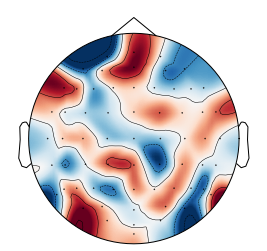

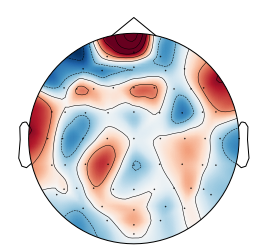

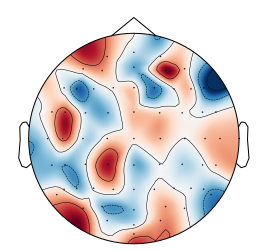

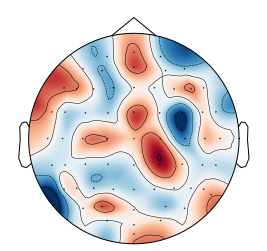

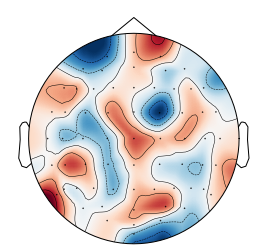

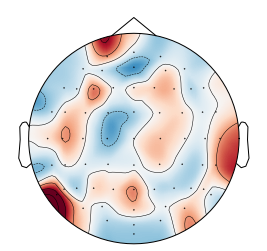

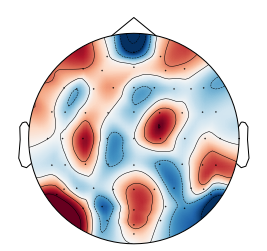

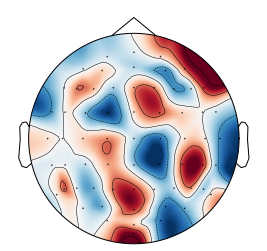

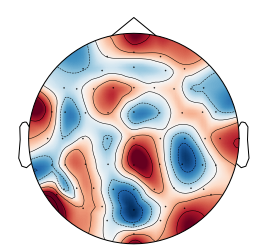

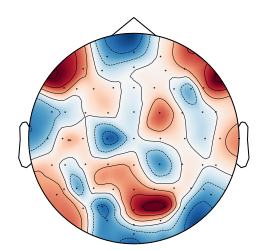

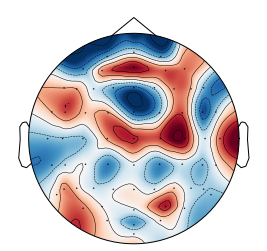

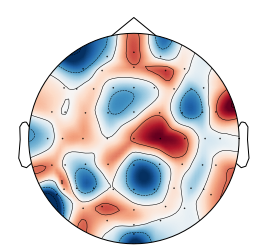

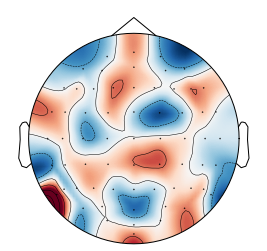

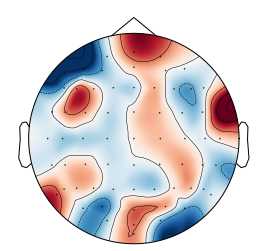

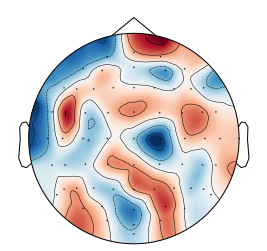

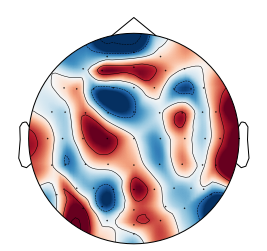

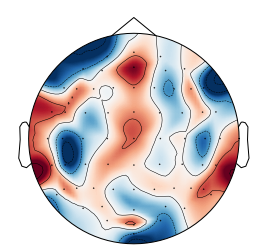

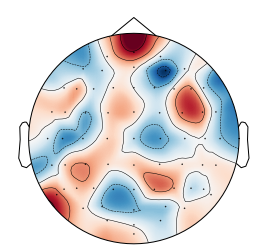

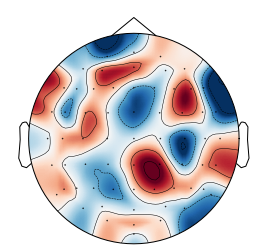

In [47]:
import mne
imgs = model.layers[1].weights[0].numpy()[:,0,:]
print(imgs.shape)
for i in range(20):
    data = imgs[:,i]
    mne.viz.plot_topomap(data, info)


# Evaluate

In [21]:
n_samples = 2
settings = dict(duration_of_trial=0.2, extents=(1, 40), number_of_sources=(1,15), target_snr=1e99)
# settings = dict(duration_of_trial=0.1, extents=(1,40), number_of_sources=15, target_snr=1e99)
# settings = dict(duration_of_trial=0.01, extents=25, number_of_sources=1, target_snr=1e99)
sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)

X_test = np.stack([eeg.average().data for eeg in sim_test.eeg_data], axis=0)
y_test = np.stack([source.data for source in sim_test.source_data], axis=0)
X_test, y_test = prep_data(X_test, y_test)

X_test = np.swapaxes(X_test, 1, 2)
X_test = np.expand_dims(X_test, axis=-1)
y_test = np.swapaxes(y_test, 1, 2)
y_test = np.expand_dims(y_test, axis=-1)

stc = sim_test.source_data[0]
stc.data /= np.max(abs(stc.data))
stc.plot(**plot_params, brain_kwargs=dict(title="Ground Truth Sim"))

y_hat = model.predict(X_test)[0]
# y_hat = model_fc.predict(X_test)[0]
stc_hat = stc.copy()
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title="CNN"))
from scipy.stats import pearsonr
from esinet.evaluate import eval_auc
_, pos = util.unpack_fwd(fwd)[1:3]
auc = np.mean([np.mean(eval_auc(y_true, y_pred, pos)) for y_true, y_pred in zip(stc.data.T, stc_hat.data.T)])
cosine = tf.keras.losses.CosineSimilarity()(tf.cast(stc.data.T, dtype=tf.float32), tf.cast(stc_hat.data.T, dtype=tf.float32)).numpy()
r,p = pearsonr(stc.data.flatten(), stc_hat.data.flatten())
print(f'auc={auc:.2f}, cosine={cosine}, r={r:.2f}, p={p:.4f}\n')

# y_hat = model.predict(X_test)[0]
y_hat = model_fc.predict(X_test)[0]
stc_hat = stc.copy()
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title="CNN"))
from scipy.stats import pearsonr
from esinet.evaluate import eval_auc
_, pos = util.unpack_fwd(fwd)[1:3]
auc = np.mean([np.mean(eval_auc(y_true, y_pred, pos)) for y_true, y_pred in zip(stc.data.T, stc_hat.data.T)])
cosine = tf.keras.losses.CosineSimilarity()(tf.cast(stc.data.T, dtype=tf.float32), tf.cast(stc_hat.data.T, dtype=tf.float32)).numpy()
r,p = pearsonr(stc.data.flatten(), stc_hat.data.flatten())
print(f'auc={auc:.2f}, cosine={cosine}, r={r:.2f}, p={p:.4f}\n')

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 94.20it/s]


auc=0.99, cosine=-0.5247565507888794, r=0.54, p=0.0000

auc=1.00, cosine=-0.641497015953064, r=0.65, p=0.0000



Using control points [1.33105724e-05 1.85885684e-05 8.51098814e-05]
Using control points [1.88798290e-05 2.86961344e-05 1.23824528e-04]
Using control points [1.88798290e-05 2.86961344e-05 1.23824528e-04]
Using control points [1.25916246e-05 1.53795283e-04 4.89184654e-02]
Using control points [1.33105724e-05 1.85885684e-05 8.51098814e-05]
Using control points [1.88798290e-05 2.86961344e-05 1.23824528e-04]
Using control points [1.88798290e-05 2.86961344e-05 1.23824528e-04]
Using control points [1.88798290e-05 2.86961344e-05 1.23824528e-04]
Using control points [1.88798290e-05 2.86961344e-05 1.23824528e-04]
Using control points [1.88798290e-05 2.86961344e-05 1.23824528e-04]
Using control points [1.33105724e-05 1.85885684e-05 8.51098814e-05]
Using control points [1.33105724e-05 1.85885684e-05 8.51098814e-05]
Using control points [1.33105724e-05 1.85885684e-05 8.51098814e-05]
Using control points [1.33105724e-05 1.85885684e-05 8.51098814e-05]
Using control points [1.33105724e-05 1.85885684e

In [ ]:
sys.path.insert(0, '../../invert/')
from invert.solvers.minimum_norm_estimates import SolverDynamicStatisticalParametricMapping
from invert.solvers.wrop import SolverLAURA
from invert.solvers.empirical_bayes import SolverChampagne

# solver = SolverLAURA().make_inverse_operator(fwd)
solver = SolverChampagne().make_inverse_operator(fwd)

stc_mne = solver.apply_inverse_operator(sim_test.eeg_data[0].average())
stc_mne.data = stc_mne.data / np.max(abs(stc_mne.data))
stc_mne.plot(**plot_params, brain_kwargs=dict(title=solver.name))

_, pos = util.unpack_fwd(fwd)[1:3]
auc = np.mean([np.mean(eval_auc(y_true, y_pred, pos)) for y_true, y_pred in zip(stc.data.T, stc_mne.data.T)])
cosine = tf.keras.losses.CosineSimilarity()(tf.cast(stc.data.T, dtype=tf.float32), tf.cast(stc_mne.data.T, dtype=tf.float32)).numpy()
r,p = pearsonr(stc.data.flatten(), stc_mne.data.flatten())
print(f'auc={auc:.2f}, cosine={cosine}, r={r:.2f}, p={p:.4f}\n')

# Test Discriminator with Generator

In [ ]:
# generated data:
y = generate_samples(g_model, 32, latent_dim)
X = (leadfield @ y.T).T
X, y = prep_data(X,y)

y[np.isnan(y)] = 0
stc_hat.data = y.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title="Ground Truth"), clim=dict(kind='value', pos_lims=(0, 0.5, 1)))

y_hat = d_model.predict(X)
y_hat[np.isnan(y_hat)] = 0

stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title="GAN"), clim=dict(kind='value', pos_lims=(0, 0.5, 1)))

r,p = pearsonr(y.flatten(), y_hat.flatten())
auc = np.mean([np.mean(eval_auc(yy_true, yy_pred, pos)) for yy_true, yy_pred in zip(y, y_hat)])

print(f'auc={auc:.2f}, r={r:.2f}, p={p:.4f}\n')

# Linear Solution

In [ ]:
sys.path.insert(0, '../../invert/')
from invert.solvers.minimum_norm_estimates import SolverDynamicStatisticalParametricMapping
from invert.solvers.wrop import SolverLAURA

evoked = mne.EvokedArray(X[:, 0, :].T, info)

# solver = SolverLAURA().make_inverse_operator(fwd)
solver = SolverChampagne().make_inverse_operator(fwd)
stc_mne = solver.apply_inverse_operator(evoked)
stc_mne.data = stc_mne.data / np.max(abs(stc_mne.data))
stc_mne.plot(**plot_params, brain_kwargs=dict(title=solver.name))
r,p = pearsonr(y[:, 0, :].flatten(), stc_mne.data.flatten())
auc = np.mean([np.mean(eval_auc(yy_true, yy_pred, pos)) for yy_true, yy_pred in zip(y[:, 0, :].T, stc_mne.data .T)])

print(f'auc={auc:.2f}, r={r:.2f}, p={p:.4f}\n')

## old functions

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Input, Lambda
import numpy as np


basic_sources = np.identity(n_dipoles)
basic_sources = laplace_operator @ basic_sources
basic_sources = np.concatenate([basic_sources, -1*basic_sources], axis=1)
basic_eeg = leadfield @ basic_sources
print(basic_sources.shape, basic_eeg.shape)

n_chans, n_dipoles = leadfield.shape

def define_generator(latent_dim):
    g_model = tf.keras.Sequential()
    input_shape = (None, latent_dim)
    g_model.add(InputLayer(input_shape=input_shape))
    g_model.add(Dense(latent_dim, name="HL1"))
    g_model.add(Dense(n_dipoles, name="Output"))
    # g_model.build()
    # g_model.compile(optimizer='adam', loss="mse")
    # g_model.summary()
    return g_model
    
def define_discriminator(hidden_units=100):
    input_shape = (None, n_chans)
    d_model = tf.keras.Sequential()
    d_model.add(InputLayer(input_shape=input_shape))
    d_model.add(Dense(hidden_units, name="HL1"))
    d_model.add(Dense(n_dipoles, name="Output"))
    d_model.build()
    d_model.compile(optimizer='adam', loss=tf.keras.losses.CosineSimilarity())
    # d_model.summary()
    return d_model

def define_gan(g_model, d_model, latent_dim):
    leadfield_ = tf.cast(leadfield, dtype=tf.float32)
    d_model.trainable = False
    
    input_shape = (None, latent_dim)
    
    lam = Lambda(lambda x: tf.transpose(tf.linalg.matmul(leadfield_, tf.transpose(x))), output_shape=(None, n_chans))(g_model.output)
    print(lam)
    discriminator = d_model(lam)
    model = tf.keras.Model(inputs=g_model.input, outputs=[d_model.output, g_model.output], name='Contextualizer')


    # model = tf.keras.Sequential()
    # model.add(g_model)
    # model.add(Lambda(lambda x: tf.linalg.matmul(leadfield_, x)))
    # model.add(d_model)
    # model.compile(loss='binary_crossentropy', optimizer="adam")

    return model
 

